# Analyse des lieux de naissance // partis politiques

Dans ce carnet est proposée une analyse des spécificités des genres, en relation avec le temps et les lieux de naissance, selon un codage ville-campagne-étranger.



In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [44]:
### Librairies déjà installées avec Python
import pprint
import sqlite3 as sql

In [45]:
from fanalysis.ca import CA 
from fanalysis.mca import MCA

### Importer les données à analyser

In [46]:
### Se connecter à la base de données dans laquelle on va insérer
# le résultat de la requête SPARQL
cn = sql.connect('../../data/conseil_national_import.db')
cn

In [47]:
qr = """
SELECT wp.personne_uri, wp.nom_prenom,  wg.genre_code AS genre_code, wp2.parti_code AS parti_code, wp2.parti_uri AS parti_uri,
 max(wp.annee_naissance) AS annee_naissance,
   max(wln.code_lieu) AS lieu
FROM 
    wdt_personnes wp
JOIN 
    wdt_lieu_naissance wln ON wln.id = wp.fk_lieu_naissance_id 
JOIN 
    wdt_personnes_partis wpp ON wp.id = wpp.fk_personne_id
JOIN 
    wdt_partis wp2 ON wp2.id = wpp.fk_parti_id
JOIN 
    wdt_genre wg ON wp.fk_genre_id = wg.id
    
GROUP BY wp.personne_uri, nom_prenom;

"""

In [48]:
### Vérifier que les données ont été importées correctement
cur = cn.cursor()
l = cur.execute(qr).fetchall()
print(len(l))
l[:3]

885


[('http://www.wikidata.org/entity/Q1029622',
  'Regula Rytz',
  'F',
  'Verts',
  'http://www.wikidata.org/entity/Q659739',
  1962,
  'V'),
 ('http://www.wikidata.org/entity/Q1039793',
  'Carl Miville-Seiler',
  'M',
  'PS',
  'http://www.wikidata.org/entity/Q303745',
  1921,
  'V'),
 ('http://www.wikidata.org/entity/Q105607582',
  'Fabienne Bugnon',
  'F',
  'Verts',
  'http://www.wikidata.org/entity/Q659739',
  1959,
  'V')]

In [49]:
### Créer un DataFrame contenant les données
df_lieu_naissance = pd.DataFrame(l, columns=['uri', 'nom', 'genre', 'parti', 'parti_uri','annee_nais', 
                     'lieu'])
df_lieu_naissance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885 entries, 0 to 884
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uri         885 non-null    object
 1   nom         885 non-null    object
 2   genre       885 non-null    object
 3   parti       885 non-null    object
 4   parti_uri   885 non-null    object
 5   annee_nais  885 non-null    int64 
 6   lieu        885 non-null    object
dtypes: int64(1), object(6)
memory usage: 48.5+ KB


## regroupement des partis par orientation

In [50]:

def orientation_code(o_uri):
    if o_uri == 'http://www.wikidata.org/entity/Q303745':
        # PS
        a = 'gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q385258':
        # UDC
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q13850128':
        # PRD
        a = 'droite_liberale'
    elif o_uri =='http://www.wikidata.org/entity/Q659461':
        # PDC
        a = 'centre'
    elif o_uri =='http://www.wikidata.org/entity/Q659739':
        # Les Verts
        a = 'ecologiste'
    elif o_uri =='http://www.wikidata.org/entity/Q202638':
        # PLR
        a = 'droite_liberale'
    elif o_uri =='http://www.wikidata.org/entity/Q667785':
        # PLS
        a = 'droite_liberale'
    elif o_uri =='http://www.wikidata.org/entity/Q550295':
        # alliance des indépendants
        a = 'independant'
    elif o_uri =='http://www.wikidata.org/entity/Q545900':
        # PVL
        a = 'droite_liberale'
    elif o_uri =='http://www.wikidata.org/entity/Q100934025':
        # le centre
        a = 'centre'
    elif o_uri =='http://www.wikidata.org/entity/Q151768':
        # parti bourgeois démocrate
        a = 'centre'
    elif o_uri =='http://www.wikidata.org/entity/Q477228':
        # parti des paysans et artisans indépendants
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q667718':
        # parti évangélique suisse
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q661771':
        # parti suisse du travail
        a = 'extreme_gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q660046':
        # démocrates suisse ou action nationale
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q668101':
        # ligue des Tessinois
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q2145393':
        # mouvement républicain
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q667836':
        # union démocratique fédérale
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q681843':
        # parti démocrate suisse
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q667725':
        # parti chrétien social
        a = 'centre'
    elif o_uri =='http://www.wikidata.org/entity/Q663580':
        # mouvement citoyens genevois
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q362949':
        # organisation progressistes de Suisse
        a = 'extreme_gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q327591':
        # indépendant
        a = 'independant'
    elif o_uri =='http://www.wikidata.org/entity/Q13124':
        # parti libéral démocrate
        a = 'droite_liberale'
    elif o_uri =='http://www.wikidata.org/entity/Q684909':
        # collection fédérale Eidgenössische Sammlung
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q677491':
        # mouvement socio-libéral
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q672946':
        # parti suisse de la liberté
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q672926':
        # front national
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q3366732':
        # parti socialiste autonome
        a = 'gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q3366188':
        # parti chrétien-social indépendant
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q286683':
        # solidaritéS
        a = 'extreme_gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q255650':
        # la Gauche alternative linke
        a = 'gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q20012603':
        # ensemble à gauche
        a = 'extreme_gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q13142801':
        # Neue Front
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q1254507':
        # alliance verte et sociale bernoise, grünes bündnis
        a = 'ecologiste'
    elif o_uri =='http://www.wikidata.org/entity/Q1186111':
        # demokratisch-soziale partei
        a = 'centre'
    elif o_uri =='http://www.wikidata.org/entity/Q1084149':
        # parti chrétien-social d'obwald
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q10594788':
        # action nationale pour le peuple et la patrie
        a = 'extreme_droite'
    else :
        # orientation autre
        a = 'A'
    return a 


### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_lieu_naissance['orientation_code'] = df_lieu_naissance.apply(lambda x: orientation_code(x['parti_uri']), axis=1)

In [51]:
### Distribution des partis
df_lieu_naissance.groupby(by='orientation_code').size().sort_values(ascending=False)

orientation_code
centre                  304
gauche                  208
extreme_droite          155
droite_liberale          99
ecologiste               64
independant              27
droite_conservatrice     21
extreme_gauche            7
dtype: int64

### Codage par périodes

In [52]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df_lieu_naissance['annee_nais'] = df_lieu_naissance['annee_nais'].astype(int)

In [53]:
# Sélection des lignes où 'annee_nais' < 2020 et 'lieu' n'est pas égal à 'E'
cdf_p = df_lieu_naissance[(df_lieu_naissance['annee_nais'] < 2020) & (df_lieu_naissance['lieu'] != 'E')].copy(deep=True)

cdf_p.head(3)

## afin de concentrer l'analyse uniquement sur les répartitions ville-campagne, j'ai éliminé du dataframe les individus dont
## le lieu étaient E, d'une part car il y en avait que 29 et d'autres par car il sortait quelque peu de l'analyse

,uri,nom,genre,parti,parti_uri,annee_nais,lieu,orientation_code
0,http://www.wikidata.org/entity/Q1029622,Regula Rytz,F,Verts,http://www.wikidata.org/entity/Q659739,1962,V,ecologiste
1,http://www.wikidata.org/entity/Q1039793,Carl Miville-Seiler,M,PS,http://www.wikidata.org/entity/Q303745,1921,V,gauche
2,http://www.wikidata.org/entity/Q105607582,Fabienne Bugnon,F,Verts,http://www.wikidata.org/entity/Q659739,1959,V,ecologiste


In [54]:
### Année minimale et maximale dans la population
min(cdf_p['annee_nais']), max(cdf_p['annee_nais'])

(1901, 1994)

In [55]:
## les périodes sont définies dans le github et se basent sur des changements majeurs du 20e siècle
l_per = [1901, 1915, 1930, 1946, 1976, 1997]

In [56]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_p['periodes'] = pd.cut(cdf_p['annee_nais'], l_per, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,uri,nom,genre,parti,parti_uri,annee_nais,lieu,orientation_code,periodes
0,http://www.wikidata.org/entity/Q1029622,Regula Rytz,F,Verts,http://www.wikidata.org/entity/Q659739,1962,V,ecologiste,1946-1975
1,http://www.wikidata.org/entity/Q1039793,Carl Miville-Seiler,M,PS,http://www.wikidata.org/entity/Q303745,1921,V,gauche,1915-1929
2,http://www.wikidata.org/entity/Q105607582,Fabienne Bugnon,F,Verts,http://www.wikidata.org/entity/Q659739,1959,V,ecologiste,1946-1975


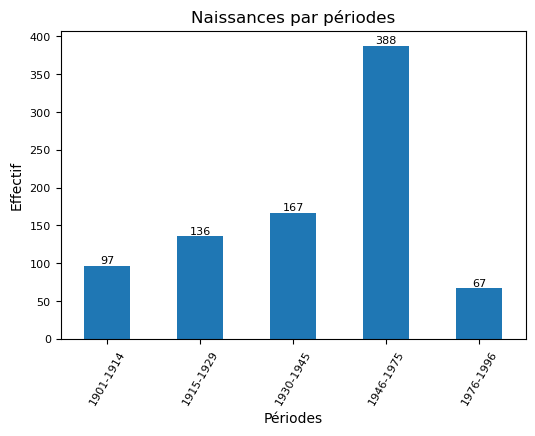

In [57]:
ax = cdf_p.groupby(by='periodes', observed=True).size()\
      .plot(kind='bar',rot=60, fontsize=8, figsize=(6,4))

ax.bar_label(ax.containers[0], fontsize=8)

plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes')
plt.show()

### Distributions des genres par périodes

In [58]:
### Tableau de contingence
X = "periodes"  # "0"
Y = "orientation_code"

ddf = cdf_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

C:\Users\LZender\AppData\Local\Temp\ipykernel_4468\4089954143.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  ddf = cdf_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)


periodes,1901-1914,1915-1929,1930-1945,1946-1975,1976-1996,Total
orientation_code,,,,,,
centre,41,71,82,100,6,300
droite_conservatrice,1,3,3,12,1,20
droite_liberale,7,6,7,63,12,95
ecologiste,0,1,7,43,10,61
extreme_droite,11,15,27,79,18,150
extreme_gauche,1,3,0,3,0,7
gauche,27,30,32,87,20,196
independant,9,7,9,1,0,26
Total,97,136,167,388,67,855


In [59]:
### Production du tableau à analyser
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

periodes,1901-1914,1915-1929,1930-1945,1946-1975,1976-1996
orientation_code,,,,,
centre,41,71,82,100,6
droite_conservatrice,1,3,3,12,1
droite_liberale,7,6,7,63,12
ecologiste,0,1,7,43,10
extreme_droite,11,15,27,79,18
extreme_gauche,1,3,0,3,0
gauche,27,30,32,87,20
independant,9,7,9,1,0


In [60]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 8 , 5 ), effectif: 855 , nombre max. facteurs: 4


In [61]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 152.48090763371493 , dof : 28
p-value : 4.396975520464981e-19
phi2 = inertie (variance totale) : 0.17834024284645023
Cramer:  0.21115174806667492


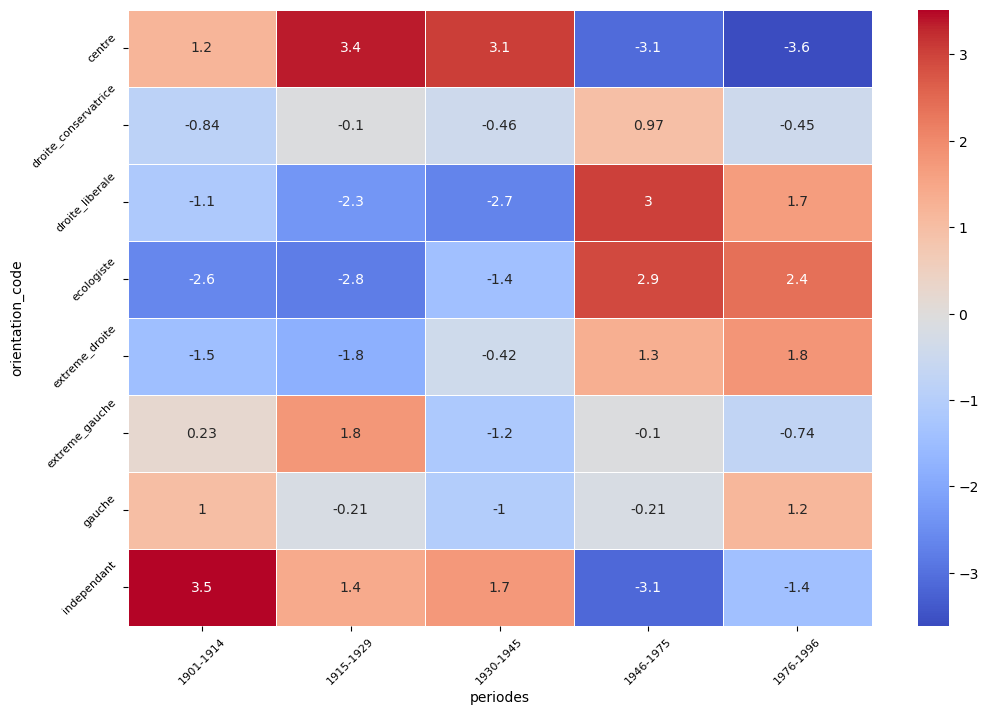

In [62]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(12,8))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=45, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=45, fontsize=8)

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('images/orientations_par_périodes_.jpg', bbox_inches='tight',
                       pad_inches=0.2)
plt.show()


#### Commentaire

Comme la variable 'gender' a deux modalités un seul facteur résumé la variance et une analyse factorielle n'est pas utile.

### Distributions des partis suivant le lieu de naissance

In [63]:
### Tableau de contingence
X = "orientation_code"
Y = "lieu"

ddf = cdf_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant,Total
lieu,,,,,,,,,
C,156,10,25,24,71,1,66,8,361
V,144,10,70,37,79,6,130,18,494
Total,300,20,95,61,150,7,196,26,855


Si cette table de contingence concerne l'ensemble de la population, on utilise pour la suite la même population que pour l'analyse précédente, limitée donc dans le temps et sans le lieu 'E'.

In [64]:
### Tableau de contingence
X = "orientation_code"
Y = "lieu"

ddf = cdf_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant,Total
lieu,,,,,,,,,
C,156,10,25,24,71,1,66,8,361
V,144,10,70,37,79,6,130,18,494
Total,300,20,95,61,150,7,196,26,855


In [65]:
### Production du tableau à analyser
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant
lieu,,,,,,,,
C,156,10,25,24,71,1,66,8
V,144,10,70,37,79,6,130,18


In [66]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 2 , 8 ), effectif: 855 , nombre max. facteurs: 1


In [67]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 33.42848751436896 , dof : 7
p-value : 2.202728166013198e-05
phi2 = inertie (variance totale) : 0.03909764621563621
Cramer:  0.19773124744368606


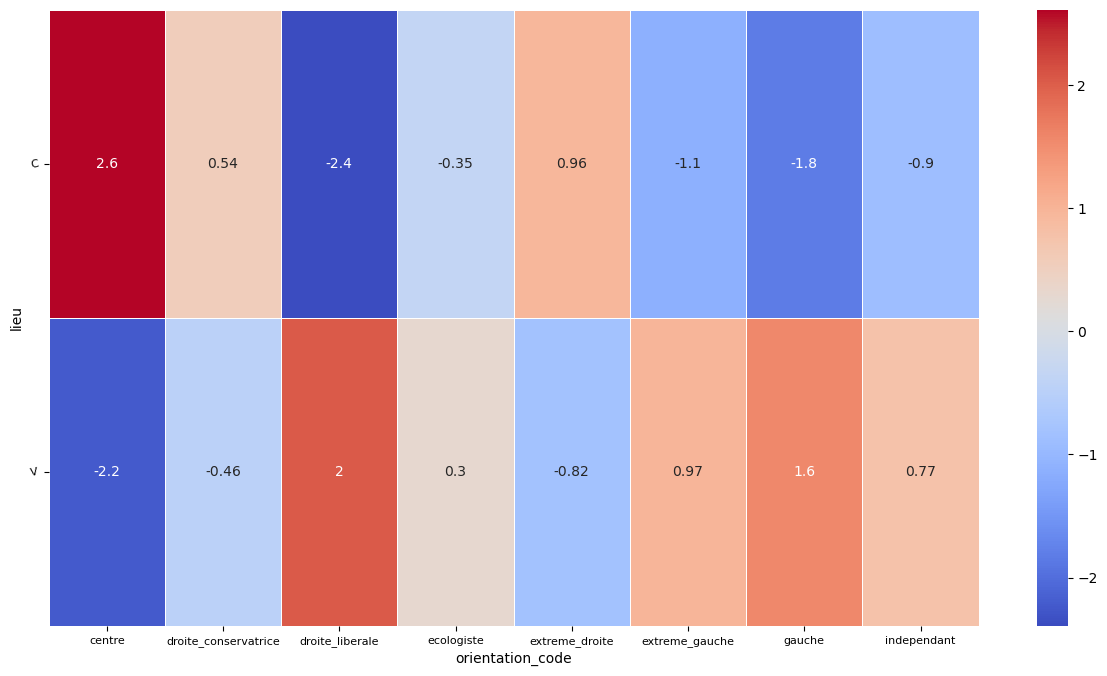

In [68]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(15,8))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, 
                cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=0, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=10, fontsize=8)


# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('images/lieu_par_parti.jpg', bbox_inches='tight',
                       pad_inches=0.2)
plt.show()


## Analyser le lien entre parti+période et les lieux de naissance

Cette analyse plus fine permet de comparer trois variable mais dans une logique bivariée

In [69]:
cdf_p.periodes = cdf_p.periodes.astype("str")
cdf_p.info()

<class 'pandas.core.frame.DataFrame'>
Index: 855 entries, 0 to 884
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   uri               855 non-null    object
 1   nom               855 non-null    object
 2   genre             855 non-null    object
 3   parti             855 non-null    object
 4   parti_uri         855 non-null    object
 5   annee_nais        855 non-null    int32 
 6   lieu              855 non-null    object
 7   orientation_code  855 non-null    object
 8   periodes          855 non-null    object
dtypes: int32(1), object(8)
memory usage: 63.5+ KB


In [70]:
cdf_p['lieu_periodes'] = cdf_p.apply(lambda x: \
                    x.periodes + '_' + x.lieu, axis=1)
cdf_p.head()

,uri,nom,genre,parti,parti_uri,annee_nais,lieu,orientation_code,periodes,lieu_periodes
0,http://www.wikidata.org/entity/Q1029622,Regula Rytz,F,Verts,http://www.wikidata.org/entity/Q659739,1962,V,ecologiste,1946-1975,1946-1975_V
1,http://www.wikidata.org/entity/Q1039793,Carl Miville-Seiler,M,PS,http://www.wikidata.org/entity/Q303745,1921,V,gauche,1915-1929,1915-1929_V
2,http://www.wikidata.org/entity/Q105607582,Fabienne Bugnon,F,Verts,http://www.wikidata.org/entity/Q659739,1959,V,ecologiste,1946-1975,1946-1975_V
3,http://www.wikidata.org/entity/Q105750072,Madeleine Bernasconi,F,PRD,http://www.wikidata.org/entity/Q659461,1939,V,centre,1930-1945,1930-1945_V
4,http://www.wikidata.org/entity/Q106371824,Otto G. Loretan,M,PRD,http://www.wikidata.org/entity/Q659461,1946,C,centre,1946-1975,1946-1975_C


In [71]:
cdf_p.groupby(by='lieu_periodes').size()


lieu_periodes
1901-1914_C     52
1901-1914_V     45
1915-1929_C     71
1915-1929_V     65
1930-1945_C     77
1930-1945_V     90
1946-1975_C    143
1946-1975_V    245
1976-1996_C     18
1976-1996_V     49
dtype: int64

In [72]:
### Tableau de contingence
X = "lieu_periodes"
Y = "orientation_code"

ddf = cdf_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

lieu_periodes,1901-1914_C,1901-1914_V,1915-1929_C,1915-1929_V,1930-1945_C,1930-1945_V,1946-1975_C,1946-1975_V,1976-1996_C,1976-1996_V,Total
orientation_code,,,,,,,,,,,
centre,24,17,41,30,43,39,45,55,3,3,300
droite_conservatrice,1,0,2,1,1,2,6,6,0,1,20
droite_liberale,3,4,1,5,1,6,18,45,2,10,95
ecologiste,0,0,0,1,4,3,18,25,2,8,61
extreme_droite,10,1,7,8,10,17,37,42,7,11,150
extreme_gauche,0,1,1,2,0,0,0,3,0,0,7
gauche,12,15,16,14,15,17,19,68,4,16,196
independant,2,7,3,4,3,6,0,1,0,0,26
Total,52,45,71,65,77,90,143,245,18,49,855


In [73]:
### Liste construite manuellement à partir de cette liste
# print(ddf.index.to_list())

li = ['centre', 'droite_conservatrice', 'droite_liberale', 'ecologiste', 'extreme_droite', 'extreme_gauche', 'gauche', 'independant']

In [74]:
lc = ddf.columns.to_list()[:-1]

In [75]:
D = ddf.loc[li,lc].copy(deep=True)
D

lieu_periodes,1901-1914_C,1901-1914_V,1915-1929_C,1915-1929_V,1930-1945_C,1930-1945_V,1946-1975_C,1946-1975_V,1976-1996_C,1976-1996_V
orientation_code,,,,,,,,,,
centre,24,17,41,30,43,39,45,55,3,3
droite_conservatrice,1,0,2,1,1,2,6,6,0,1
droite_liberale,3,4,1,5,1,6,18,45,2,10
ecologiste,0,0,0,1,4,3,18,25,2,8
extreme_droite,10,1,7,8,10,17,37,42,7,11
extreme_gauche,0,1,1,2,0,0,0,3,0,0
gauche,12,15,16,14,15,17,19,68,4,16
independant,2,7,3,4,3,6,0,1,0,0


In [76]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 8 , 10 ), effectif: 855 , nombre max. facteurs: 7


In [77]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 206.09352391609278 , dof : 63
p-value : 4.2395158245785457e-17
phi2 = inertie (variance totale) : 0.24104505721180441
Cramer:  0.18556672162086313


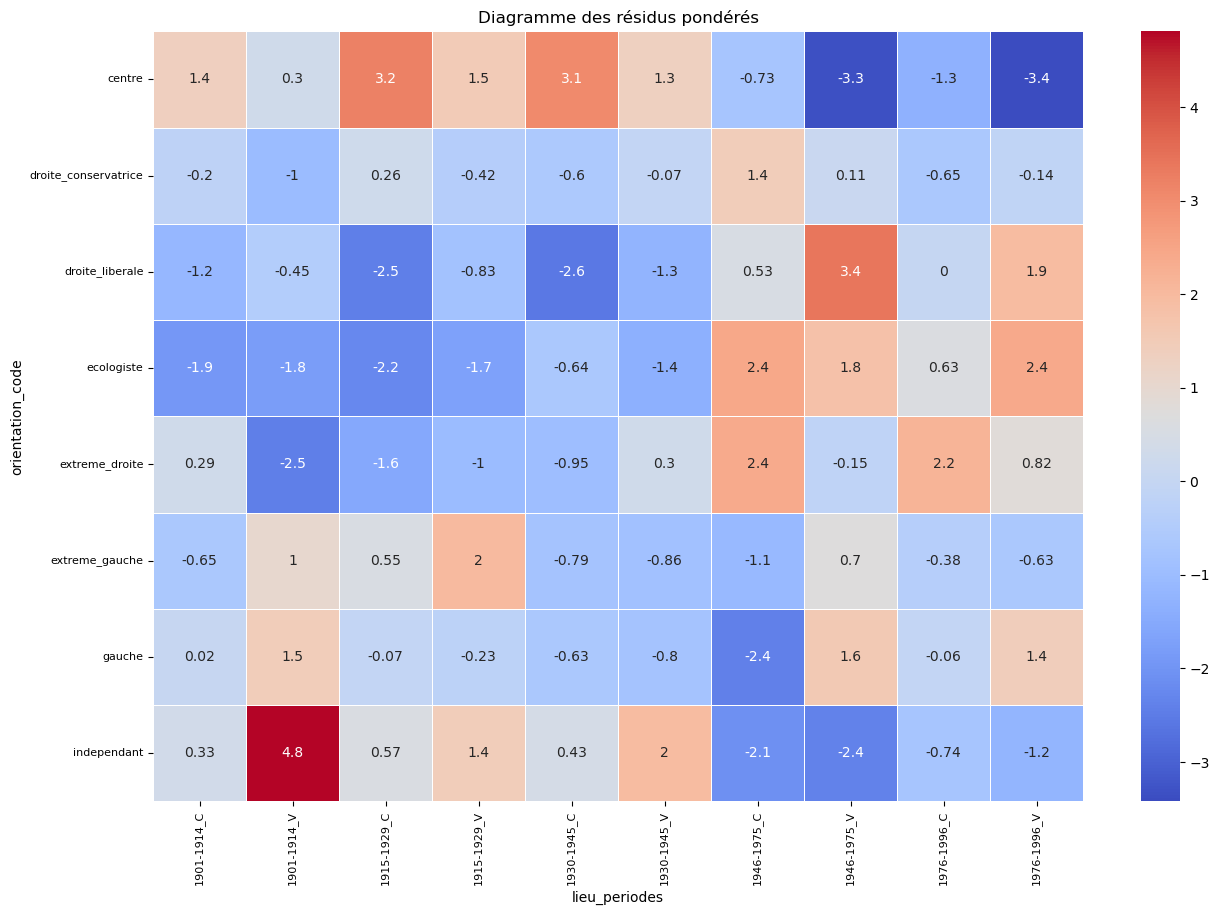

In [78]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(15,10))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, 
                cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=90, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=0, fontsize=8)


g.set_title('Diagramme des résidus pondérés')

plt.savefig('images/parti_période_lieu_resid_ponderes.jpg', bbox_inches='tight')
plt.show()


In [79]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['1901-1914_C', '1901-1914_V', '1915-1929_C', '1915-1929_V',
       '1930-1945_C', '1930-1945_V', '1946-1975_C', '1946-1975_V',
       '1976-1996_C', '1976-1996_V'],
      dtype='object', name='lieu_periodes'),
   row_labels=Index(['centre', 'droite_conservatrice', 'droite_liberale', 'ecologiste',
       'extreme_droite', 'extreme_gauche', 'gauche', 'independant'],
      dtype='object', name='orientation_code'))

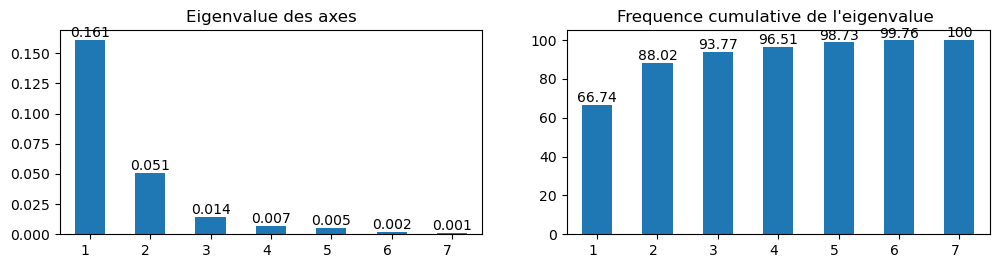

In [80]:
eig = pd.DataFrame(afc.eig_)

r1 = round(eig.iloc[0], 3)
r2 = round(eig.iloc[2], 2)
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

ax1 = r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
ax2 = r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")


ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])


# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

### Graphiques et interprétation du premier plan factoriel

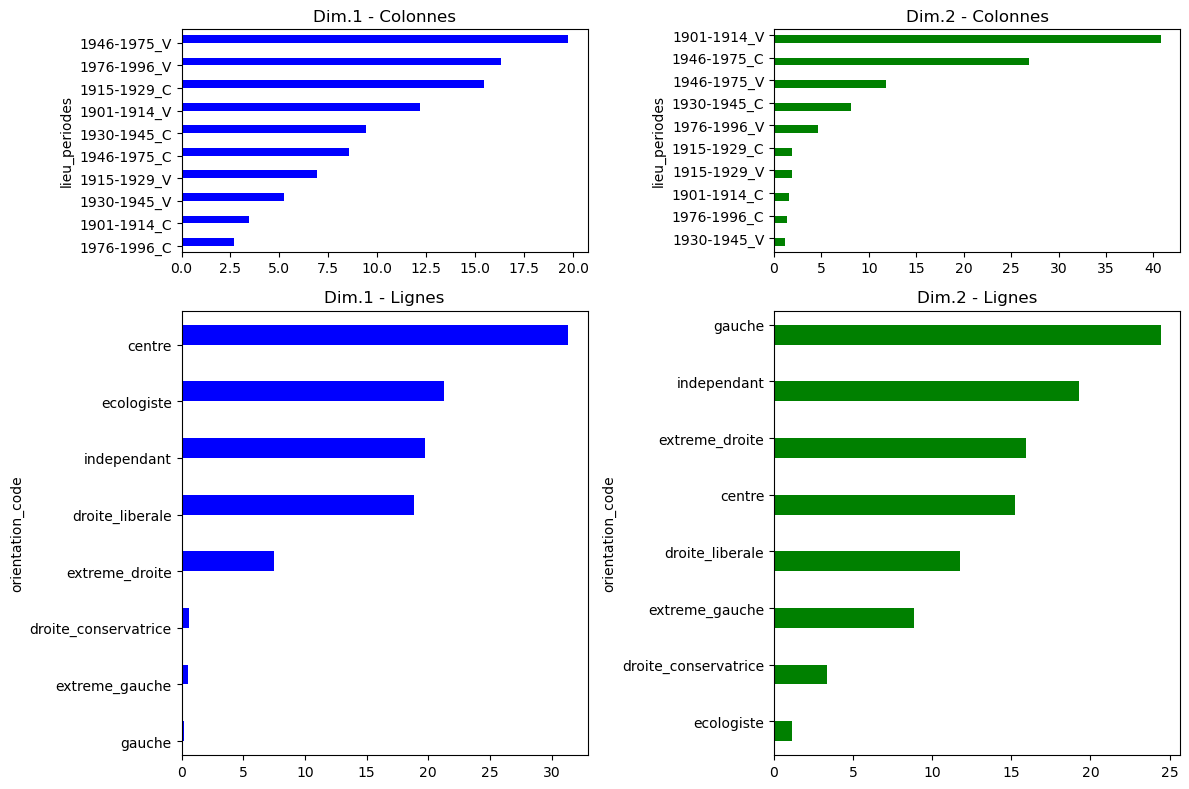

In [81]:
import matplotlib.pyplot as plt

# Informations sur les contributions des colonnes
df_col = afc.col_topandas()[['col_contrib_dim1', 'col_contrib_dim2']]

r1_col = df_col.iloc[:,0]
r2_col = df_col.iloc[:,1]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8),
                         gridspec_kw={'height_ratios': [1, 2]})

# Ajustement de l'espacement entre les barres
bar_width = 0.35
index = np.arange(len(r1_col))

r1_col.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1 - Colonnes', width=bar_width, color='b', position=0)
r2_col.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2 - Colonnes', width=bar_width, color='g', position=1)

# Informations sur les contributions des lignes
df_row = afc.row_topandas()[['row_contrib_dim1', 'row_contrib_dim2']]

r1_row = df_row.iloc[:,0]
r2_row = df_row.iloc[:,1]

r1_row.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1 - Lignes', width=bar_width, color='b', position=0)
r2_row.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2 - Lignes', width=bar_width, color='g', position=1)

# Ajustement de l'espacement vertical entre les sous-graphiques
plt.subplots_adjust(hspace=1)  # Ajustez la valeur selon vos préférences

plt.tight_layout()
plt.show()


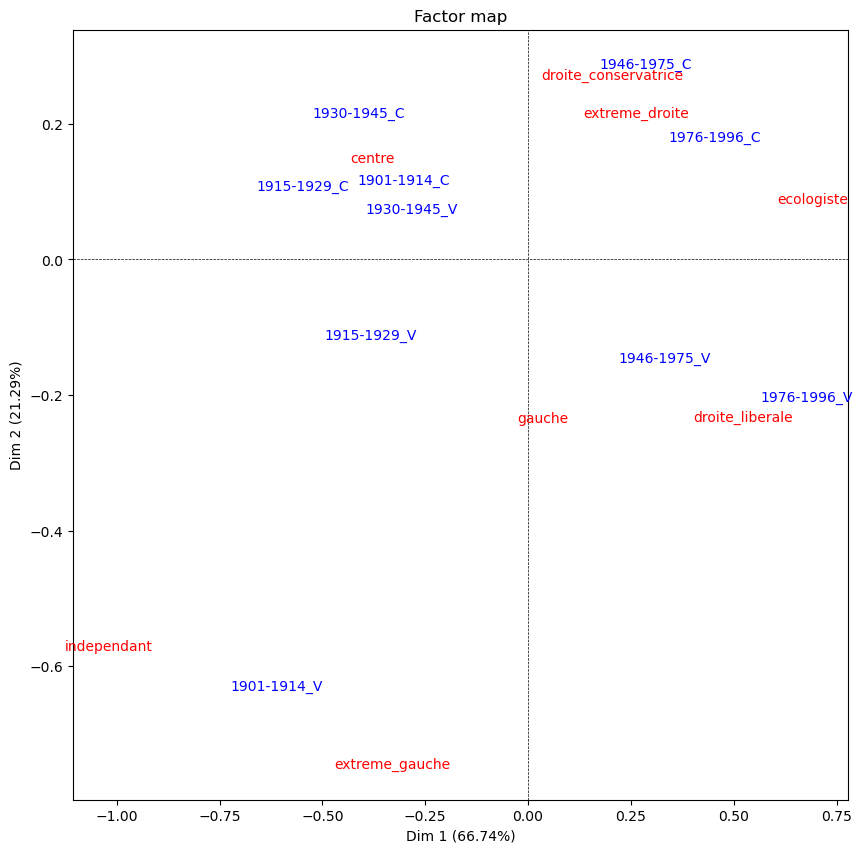

In [82]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(10,10))


### Représenter l'autre plan factoriel

## commentaire

j'ai un problème pour représenter l'autre plan factoriel car je n'ai que 2 dimensions, dû au nombre max. de facteurs

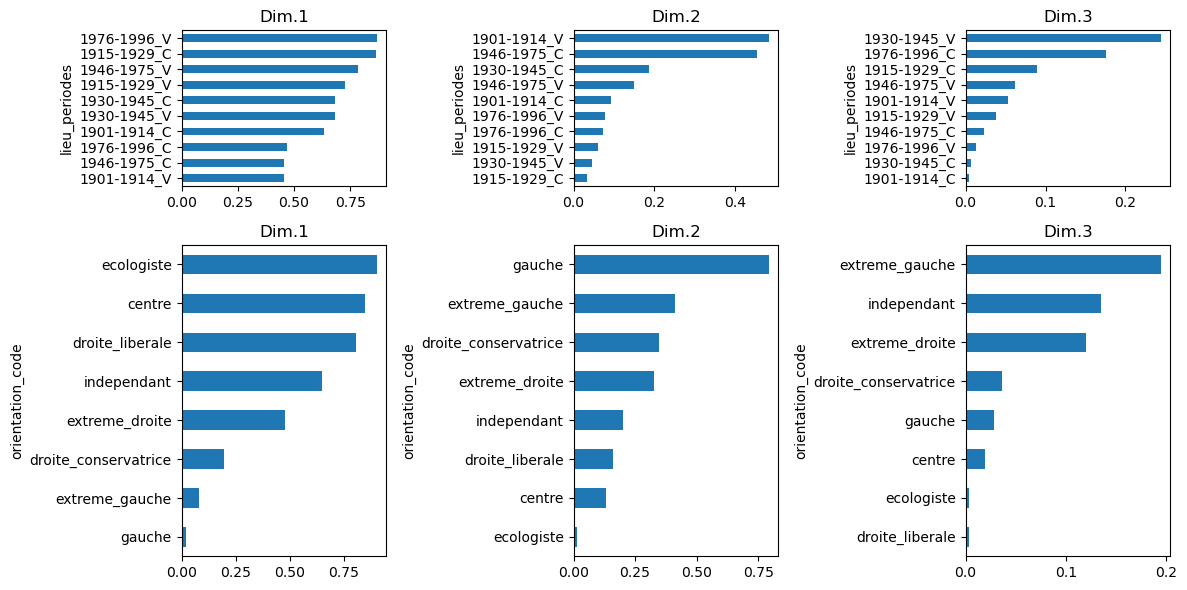

In [83]:
### Informations sur les cosinus carrés. Ces valeurs expriment 
# la qualité de représentation d'une modalité sur l'axe correspondant

### Colonnes
df = afc.col_topandas()[['col_cos2_dim1',
                         'col_cos2_dim2',
                         'col_cos2_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6), 
                         gridspec_kw={'height_ratios': [1, 2]})

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Lignes
df = afc.row_topandas()[['row_cos2_dim1',
                         'row_cos2_dim2',
                         'row_cos2_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()

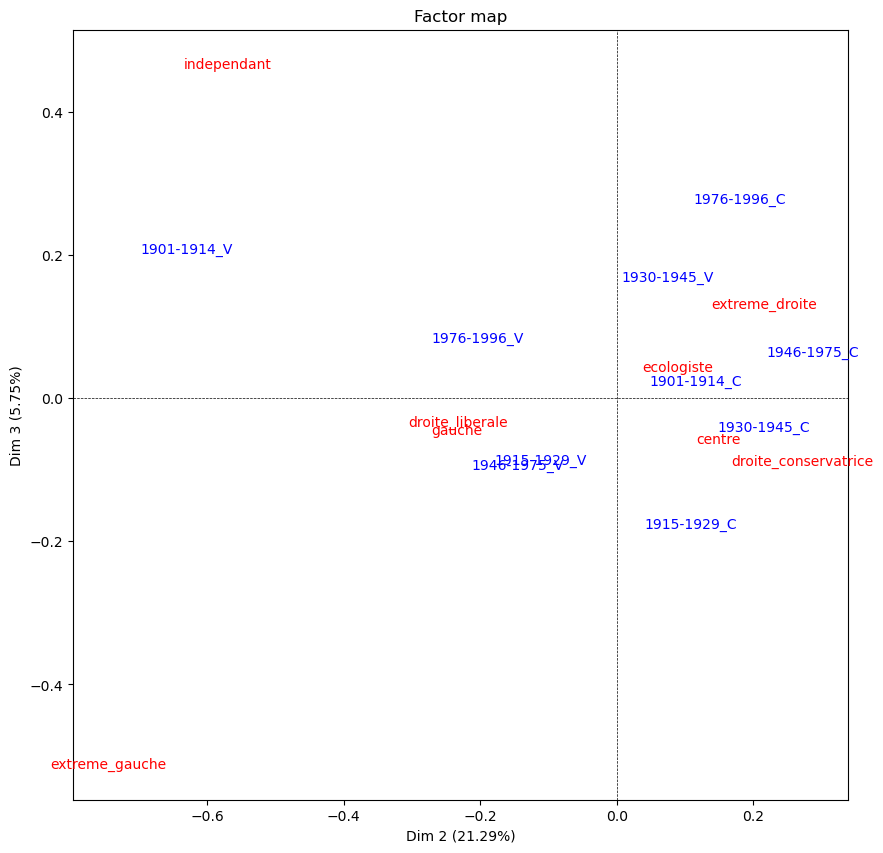

In [84]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(10,10))